In [1]:
# import all relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_palette("GnBu_d")

# also import these "new" libraries 
# Note: you may have to download an add them to your environment (using e.g. 'conda install -c conda-forge folium')

import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime
from datetime import timedelta
import math
import random
import timeit

In [2]:
# first we figure out the timeframe of our data entries
marburg = pd.read_csv("../data/marburg.csv")
duisburg = pd.read_csv("../data/duisburg.csv")


In [3]:
marburg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164205 entries, 0 to 164204
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   day            164205 non-null  object 
 1   time           164205 non-null  object 
 2   b_number       164205 non-null  int64  
 3   city           164205 non-null  object 
 4   trip_duration  164205 non-null  object 
 5   orig_lat       164205 non-null  float64
 6   orig_lng       164205 non-null  float64
 7   dest_lat       164205 non-null  float64
 8   dest_lng       164205 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 11.3+ MB


In [4]:
print("Marburg:")
print("first date: ", marburg['day'].min())
print("last date: ", marburg['day'].max())
print("")
print("Duisburg")
print("first date: ", duisburg['day'].min())
print("last date: ", duisburg['day'].max())

Marburg:
first date:  2019-01-20
last date:  2020-01-20

Duisburg
first date:  2019-01-20
last date:  2020-01-20


In [5]:
# then we figure out the location radius of our data entries

marburg_lat = pd.concat([marburg["orig_lat"], marburg["dest_lat"]], ignore_index=True)

In [6]:
print("Marburg: ")
print("min latitude: ", marburg_lat.min())
print("max latitude: ", marburg_lat.max())

Marburg: 
min latitude:  -504.153076
max latitude:  8084778.533


In [7]:
marburg["coordinates"] = list(zip(marburg["orig_lat"].round(4), marburg["orig_lng"].round(4)))

marburg_map_points = folium.Map(location=(50.80,8.765), tiles="Stamen Toner", zoom_start=9, control_scale=True, max_zoom=20)

positions = list(marburg["coordinates"].unique())

for position in positions:
    folium.CircleMarker(radius=5, location=position, popup="hello", color="crimson", fill_color="crimson").add_to(marburg_map_points)

marburg_map_points

In [93]:
marburg_precipitation = pd.read_csv("../data/marburg_precipitation.csv")
marburg_temperature = pd.read_csv("../data/marburg_temperature.csv")
marburg_temperature_two_stations = pd.read_csv("../data/marburg_temperature_two_stations.csv")

In [94]:
marburg_temperature.set_index(marburg_temperature["Zeitstempel"], inplace=True)
marburg_precipitation.set_index(marburg_precipitation["Zeitstempel"], inplace=True)

In [95]:
marburg_precipitation.head()

Produkt_Code  SDO_ID   Zeitstempel  Wert  Qualitaet_Niveau  \
Zeitstempel                                                               
201901200000     R1_MN008    3164  201901200000   0.0                 0   
201901200100     R1_MN008    3164  201901200100   0.0                 0   
201901200200     R1_MN008    3164  201901200200   0.0                 0   
201901200300     R1_MN008    3164  201901200300   0.0                 0   
201901200400     R1_MN008    3164  201901200400   0.0                 0   

              Qualitaet_Byte  
Zeitstempel                   
201901200000               3  
201901200100               3  
201901200200               3  
201901200300               3  
201901200400               3

In [96]:
marburg_precipitation.drop("Produkt_Code", axis=1, inplace=True)
marburg_precipitation.drop("SDO_ID", axis=1, inplace=True)
marburg_precipitation.drop("Zeitstempel", axis=1, inplace=True)
marburg_precipitation.drop("Qualitaet_Niveau", axis=1, inplace=True)
marburg_precipitation.drop("Qualitaet_Byte", axis=1, inplace=True)
marburg_precipitation.rename(columns={'Wert':'precipitation'}, inplace=True)
marburg_precipitation.index.rename("timestamp", inplace=True)

In [97]:
marburg_temperature.drop("Produkt_Code", axis=1, inplace=True)
marburg_temperature.drop("SDO_ID", axis=1, inplace=True)
marburg_temperature.drop("Zeitstempel", axis=1, inplace=True)
marburg_temperature.drop("Qualitaet_Niveau", axis=1, inplace=True)
marburg_temperature.drop("Qualitaet_Byte", axis=1, inplace=True)
marburg_temperature.rename(columns={'Wert':'temperature'}, inplace=True)
marburg_temperature.index.rename("timestamp", inplace=True)

In [98]:
marburg_temperature.head()

temperature
timestamp                
201901200000         -7.9
201901200100         -8.3
201901200200         -8.7
201901200300         -8.9
201901200400         -8.7

In [99]:
marburg_weather = pd.merge(marburg_temperature, marburg_precipitation, how='outer', left_index=True, right_index=True)

In [100]:
marburg_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8784 entries, 201901200000 to 202001202300
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temperature    8124 non-null   float64
 1   precipitation  8784 non-null   float64
dtypes: float64(2)
memory usage: 205.9 KB


In [101]:
def get_date(timestamp):
    return timestamp.date()

marburg_weather["datetime"] = pd.to_datetime(marburg_weather.index, format="%Y%m%d%H%M")
marburg_weather["date"] = marburg_weather["datetime"].map(get_date)

marburg_weather.set_index(marburg_weather["datetime"], inplace=True)

In [102]:
marburg_weather[marburg_weather["temperature"].isnull() == True].head()

temperature  precipitation            datetime  \
datetime                                                              
2019-07-19 01:00:00          NaN            1.4 2019-07-19 01:00:00   
2019-07-19 02:00:00          NaN            0.3 2019-07-19 02:00:00   
2019-07-19 03:00:00          NaN            0.0 2019-07-19 03:00:00   
2019-07-19 04:00:00          NaN            0.2 2019-07-19 04:00:00   
2019-07-19 05:00:00          NaN            0.1 2019-07-19 05:00:00   

                           date  temperature_interpol  
datetime                                               
2019-07-19 01:00:00  2019-07-19             17.422222  
2019-07-19 02:00:00  2019-07-19             17.844444  
2019-07-19 03:00:00  2019-07-19             18.266667  
2019-07-19 04:00:00  2019-07-19             18.688889  
2019-07-19 05:00:00  2019-07-19             19.111111

In [112]:
marburg_weather["temperature_interpol"] = marburg_weather["temperature"].interpolate(method="time")

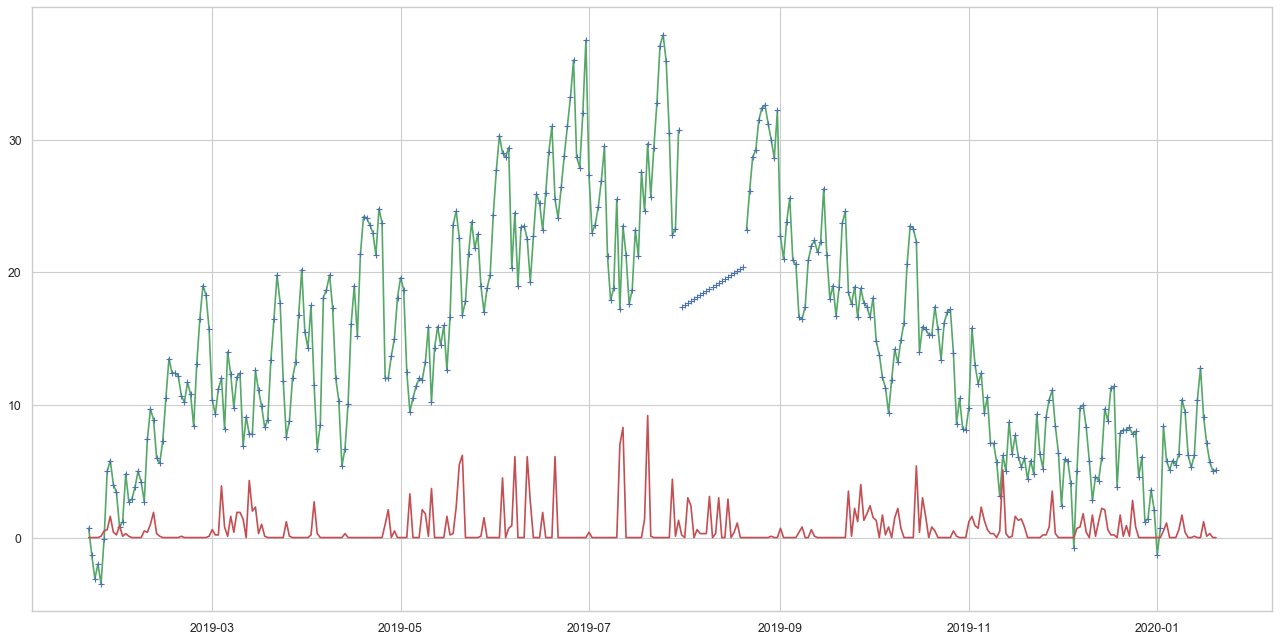

In [113]:
fix,ax = plt.subplots(figsize=(20,10), dpi=80)
marburg_weather_daily_resample = marburg_weather.resample('D').max()
ax.plot(
    marburg_weather_daily_resample.index,
    marburg_weather_daily_resample["temperature"],"g-",
    marburg_weather_daily_resample.index , 
    marburg_weather_daily_resample["temperature_interpol"], 'b+', 
    marburg_weather_daily_resample.index,
    marburg_weather_daily_resample["precipitation"], "r"
)
plt.savefig("fig.pdf")
plt.show()
# marburg_weather_daily_resample

In [23]:
marburg_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2019-01-20 00:00:00 to 2020-01-20 23:00:00
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   temperature           8124 non-null   float64       
 1   precipitation         8784 non-null   float64       
 2   datetime              8784 non-null   datetime64[ns]
 3   date                  8784 non-null   object        
 4   temperature_interpol  8784 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 411.8+ KB


In [47]:
# duisburg
duisburg_temperature = pd.read_csv("../data/duisburg_temperature.csv")
duisburg_percipitation = pd.read_csv("../data/duisburg_percipitation.csv")

In [50]:
duisburg_percipitation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Produkt_Code      8784 non-null   object 
 1   SDO_ID            8784 non-null   int64  
 2   Zeitstempel       8784 non-null   int64  
 3   Wert              8784 non-null   float64
 4   Qualitaet_Niveau  8784 non-null   int64  
 5   Qualitaet_Byte    8784 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 411.9+ KB


In [63]:
duisburg_temperature.head()

Produkt_Code  SDO_ID   Zeitstempel  Wert  Qualitaet_Niveau  Qualitaet_Byte
0  TT_TU_MN009   13670  201901200000  -1.8                 1               7
1  TT_TU_MN009   13670  201901200100  -2.5                 1               7
2  TT_TU_MN009   13670  201901200200  -2.5                 1               7
3  TT_TU_MN009   13670  201901200300  -3.1                 1               7
4  TT_TU_MN009   13670  201901200400  -3.6                 1               7

In [57]:
duisburg_percipitation.head()

Produkt_Code  SDO_ID   Zeitstempel  Wert  Qualitaet_Niveau  Qualitaet_Byte
0     R1_MN008   13670  201901200000   0.0                 0               3
1     R1_MN008   13670  201901200100   0.0                 0               3
2     R1_MN008   13670  201901200200   0.0                 0               3
3     R1_MN008   13670  201901200300   0.0                 0               3
4     R1_MN008   13670  201901200400   0.0                 0               3

In [64]:
duisburg_percipitation.drop("Produkt_Code", axis=1, inplace=True)
duisburg_percipitation.drop("SDO_ID", axis=1, inplace=True)
duisburg_percipitation.drop("Qualitaet_Niveau", axis=1, inplace=True)
duisburg_percipitation.drop("Qualitaet_Byte", axis=1, inplace=True)
duisburg_percipitation.rename(columns={'Wert':'precipitation'}, inplace=True)

In [65]:
duisburg_percipitation

Zeitstempel  precipitation
0     201901200000            0.0
1     201901200100            0.0
2     201901200200            0.0
3     201901200300            0.0
4     201901200400            0.0
...            ...            ...
8779  202001201900            0.0
8780  202001202000            0.0
8781  202001202100            0.0
8782  202001202200            0.0
8783  202001202300            0.0

[8784 rows x 2 columns]

In [66]:
duisburg_temperature.drop("Produkt_Code", axis=1, inplace=True)
duisburg_temperature.drop("SDO_ID", axis=1, inplace=True)
duisburg_temperature.drop("Qualitaet_Niveau", axis=1, inplace=True)
duisburg_temperature.drop("Qualitaet_Byte", axis=1, inplace=True)
duisburg_temperature.rename(columns={'Wert':'temperature'}, inplace=True)

In [67]:
duisburg_temperature

Zeitstempel  temperature
0     201901200000         -1.8
1     201901200100         -2.5
2     201901200200         -2.5
3     201901200300         -3.1
4     201901200400         -3.6
...            ...          ...
8779  202001201900          3.2
8780  202001202000          2.8
8781  202001202100          2.5
8782  202001202200          2.2
8783  202001202300          2.0

[8784 rows x 2 columns]

In [78]:
duisburg_weather = pd.merge(duisburg_temperature, duisburg_percipitation, how='outer', on='Zeitstempel', left_index=True, right_index=True)
duisburg_weather

Zeitstempel  temperature  precipitation
0     201901200000         -1.8            0.0
1     201901200100         -2.5            0.0
2     201901200200         -2.5            0.0
3     201901200300         -3.1            0.0
4     201901200400         -3.6            0.0
...            ...          ...            ...
8779  202001201900          3.2            0.0
8780  202001202000          2.8            0.0
8781  202001202100          2.5            0.0
8782  202001202200          2.2            0.0
8783  202001202300          2.0            0.0

[8784 rows x 3 columns]

In [79]:
duisburg_weather["datetime"] = pd.to_datetime(duisburg_weather['Zeitstempel'], format="%Y%m%d%H%M")
duisburg_weather.drop("Zeitstempel", axis=1, inplace=True)
duisburg_weather["date"] = duisburg_weather["datetime"].map(get_date)

duisburg_weather.set_index(duisburg_weather["datetime"], inplace=True)
duisburg_weather.drop("datetime", axis=1, inplace=True)

In [80]:
duisburg_weather

temperature  precipitation        date
datetime                                                   
2019-01-20 00:00:00         -1.8            0.0  2019-01-20
2019-01-20 01:00:00         -2.5            0.0  2019-01-20
2019-01-20 02:00:00         -2.5            0.0  2019-01-20
2019-01-20 03:00:00         -3.1            0.0  2019-01-20
2019-01-20 04:00:00         -3.6            0.0  2019-01-20
...                          ...            ...         ...
2020-01-20 19:00:00          3.2            0.0  2020-01-20
2020-01-20 20:00:00          2.8            0.0  2020-01-20
2020-01-20 21:00:00          2.5            0.0  2020-01-20
2020-01-20 22:00:00          2.2            0.0  2020-01-20
2020-01-20 23:00:00          2.0            0.0  2020-01-20

[8784 rows x 3 columns]

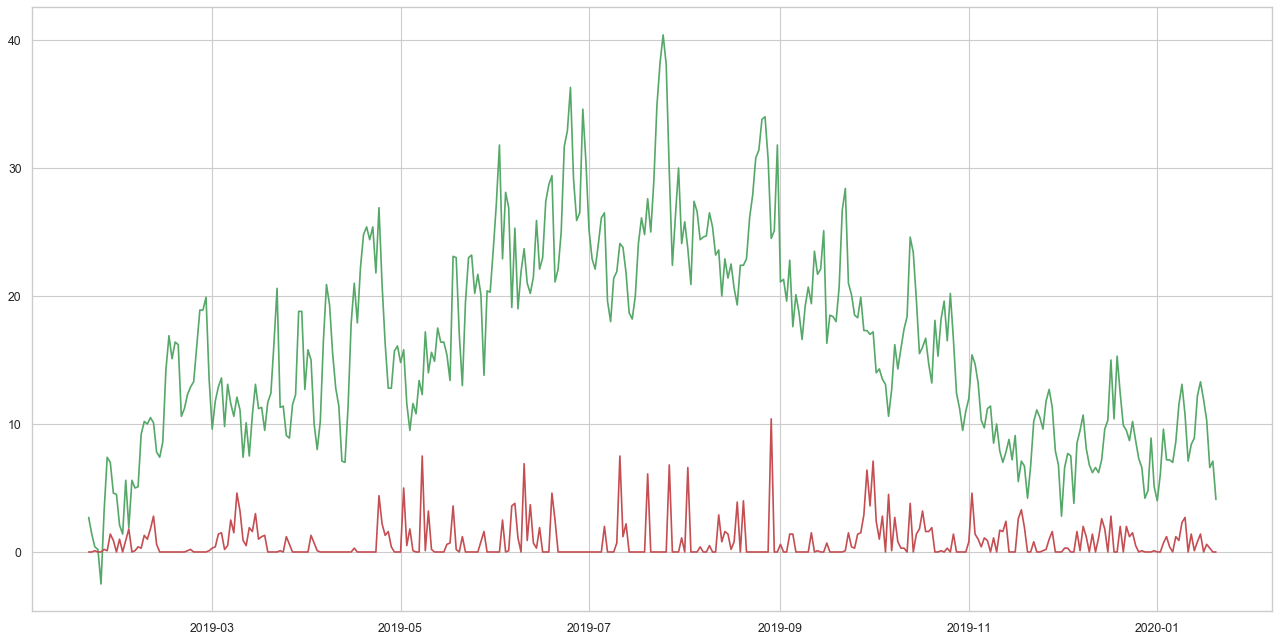

In [82]:
fix,ax = plt.subplots(figsize=(20,10), dpi=80)
duisburg_weather_daily_resample = duisburg_weather.resample('D').max()
ax.plot(
    duisburg_weather_daily_resample.index,
    duisburg_weather_daily_resample["temperature"],"g-",
    duisburg_weather_daily_resample.index,
    duisburg_weather_daily_resample["precipitation"], "r"
)
plt.savefig("fig.pdf")
plt.show()